This notebook shows how to apply CNN to predict the global temperature map, based on the 1-D time series of CO2 & CH4.

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn

from utils import * 


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()
# train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
# test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train CNN using simulations from 3 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

In [ ]:
# # Training set
# train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
# X_train_xr, X_length  = prepare_predictor(train_files,train_path)
# y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# # Test set
# X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
# y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [ ]:
# X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
#                            "CH4": X_train_xr["CH4"].data
#                           }, index=X_train_xr["CO2"].coords['time'].data)

# X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
#                            "CH4": X_test_xr["CH4"].data
#                           }, index=X_test_xr["CO2"].coords['time'].data)

# y_train = y_train_xr['tas'].data
# y_test  = y_test_xr['tas'].data

This is how our predictors & predictand data look like. Our predictors are **1-D** time series of CO2 & CH4.

In [ ]:
# X_train_df.head()

The predictand tas is **2-D** map - this point is different from the NN case

In [ ]:
# plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r',vmin=-3,vmax=3)
# plt.colorbar()

In [7]:
X_train_xr, X_length = load_and_build_X("data/INPUTS_DICT_cumsum.pkl")
y_train_xr, y_length = load_and_build_Y("data/cold_spells")
X_test_xr = build_X_test_ssp245()
y_test_xr = build_y_test_ssp245("data/cold_spells")

In [8]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2n"].mean(['latitude', 'longitude']).data,
                           "CH4": X_train_xr["CH4"].mean(['latitude', 'longitude']).data
                          }, index=X_train_xr["CO2n"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2n"].mean(['latitude', 'longitude']).data,
                           "CH4": X_test_xr["CH4"].mean(['latitude', 'longitude']).data
                          }, index=X_test_xr["CO2n"].coords['time'].data)

y_train = y_train_xr.data
y_test  = y_test_xr.data

#### Data normalization

Let's normalize the input predictors by there mean & standard deviation

In [9]:
# ==== 1. Standardize X (forcings) ====
X_mean, X_std = X_train_df.mean(), X_train_df.std()

X_train_df = (X_train_df - X_mean) / X_std
X_test_df  = (X_test_df  - X_mean) / X_std

X_train = X_train_df.to_numpy().astype("float32")   # (N_train, n_features)
X_test  = X_test_df.to_numpy().astype("float32")    # (N_test, n_features)

# ==== 2. Standardize y (cold-spell fields) ====
# assume y_train, y_test have shape (N, H, W), e.g. (N, 90, 144)
H, W = y_train.shape[1], y_train.shape[2]

# flatten spatial dims for per-gridpoint standardization
y_train_flat = y_train.reshape(y_train.shape[0], -1)   # (N_train, H*W)
y_test_flat  = y_test.reshape(y_test.shape[0],  -1)    # (N_test,  H*W)

y_mean = y_train_flat.mean(axis=0)
y_std  = y_train_flat.std(axis=0) + 1e-8   # avoid divide-by-zero

y_train_norm = (y_train_flat - y_mean) / y_std
y_test_norm  = (y_test_flat  - y_mean) / y_std

# reshape back to (N, H, W)
y_train_norm = y_train_norm.reshape(-1, H, W)
y_test_norm  = y_test_norm.reshape(-1, H, W)

# ==== 3. Convert to PyTorch tensors for CNN: (N, 1, H, W) ====
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32).unsqueeze(1)
y_test_tensor  = torch.tensor(y_test_norm,  dtype=torch.float32).unsqueeze(1)

X_train_tensor = torch.from_numpy(X_train)   # (N_train, n_features)
X_test_tensor  = torch.from_numpy(X_test)    # (N_test, n_features)

# ==== 4. Build datasets ====
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = torch.utils.data.TensorDataset(X_test_tensor,  y_test_tensor)

# ==== 5. Split train into train/validation ====
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)


In [10]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(753, 2) (753, 90, 144) (86, 2) (86, 90, 144)


### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

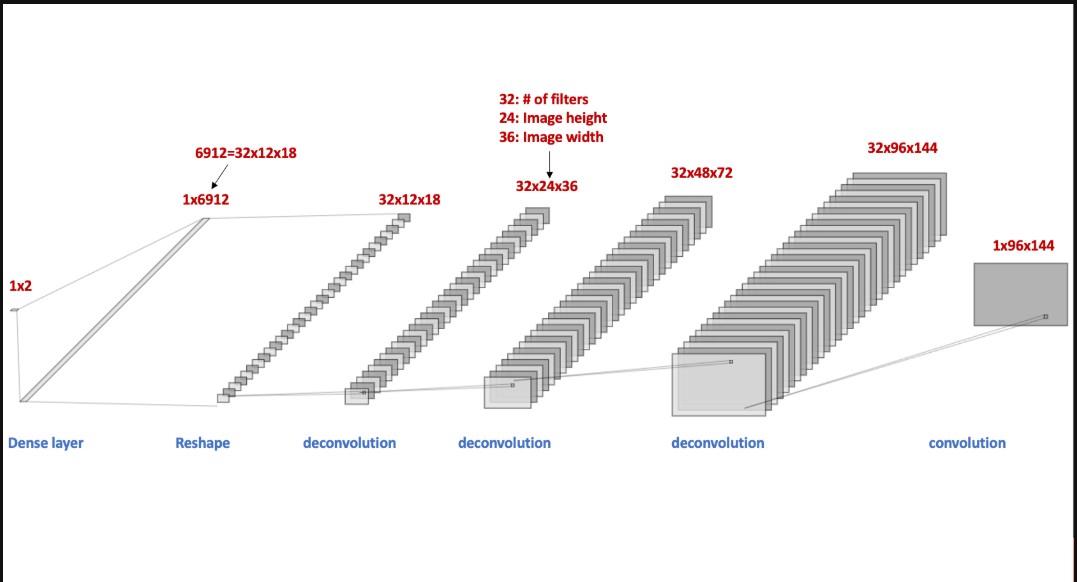

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.  

In [11]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'ReLU' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100

In [12]:
def make_CNN_model(input_dim, n_filters, activation, kernel_size):
    layers = []
    # 1) fully connected: (B, input_dim) -> (B, 32*12*18)
    layers.append(nn.Linear(input_dim, n_filters * 12 * 18))
    layers.append(getattr(nn, activation)())

    # 2) reshape to (B, C, H, W) = (B, 32, 12, 18)
    class Reshape(nn.Module):
        def __init__(self, shape):
            super().__init__()
            self.shape = shape
        def forward(self, x):
            return x.view(-1, *self.shape)

    layers.append(Reshape((n_filters, 12, 18)))

    # 3) deconv 1: 12x18 -> 24x36
    layers.append(nn.ConvTranspose2d(
        n_filters, n_filters,
        kernel_size=kernel_size,
        stride=2,
        padding=1,
        output_padding=0,
    ))
    layers.append(getattr(nn, activation)())

    # 4) deconv 2: 24x36 -> 48x72
    layers.append(nn.ConvTranspose2d(
        n_filters, n_filters,
        kernel_size=kernel_size,
        stride=2,
        padding=1,
        output_padding=0,
    ))
    layers.append(getattr(nn, activation)())

    # 5) deconv 3: 48x72 -> **90x144**
    layers.append(nn.ConvTranspose2d(
        n_filters, n_filters,
        kernel_size=kernel_size,
        stride=2,
        padding=(4, 1),   # <- key change: height padding=4, width padding=1
        output_padding=0,
    ))
    layers.append(getattr(nn, activation)())

    # 6) final conv: keep 90x144, go from 32 channels -> 1
    layers.append(nn.Conv2d(
        n_filters, 1,
        kernel_size=3,
        padding=1,
    ))

    return nn.Sequential(*layers)


In [13]:
model_mse = make_CNN_model(input_dim=X_train.shape[1],
                       n_filters=n_filters,
                       activation='ReLU',
                       kernel_size=kernel_size)

dummy = torch.randn(4, X_train.shape[1])   # batch_size=4
out = model_mse(dummy)
print(out.shape)  # should be: torch.Size([4, 1, 90, 144])


torch.Size([4, 1, 90, 144])


In [14]:
print("Model:")
print(model_mse)
print(f"\nTotal parameters: {sum(p.numel() for p in model_mse.parameters())}")

Model:
Sequential(
  (0): Linear(in_features=2, out_features=6912, bias=True)
  (1): ReLU()
  (2): Reshape()
  (3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(4, 1))
  (8): ReLU()
  (9): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Total parameters: 70273


### 3. Train & save the CNN model

In [11]:
def pytorch_train(model, optimizer, criterion, device):
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
       # training
       model.train()
       train_loss = 0.0
       for batch_X, batch_y in train_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           # forward pass
           optimizer.zero_grad()
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           # backward pass
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
    
        # validation
       model.eval()
       val_loss = 0.0
       with torch.no_grad():
           for batch_X, batch_y in val_loader:
               batch_X = batch_X.to(device)
               batch_y = batch_y.to(device)
               
               outputs = model(batch_X)
               loss = criterion(outputs, batch_y)
               val_loss += loss.item()
       
       train_loss /= len(train_loader)
       val_loss /= len(val_loader)
    
       train_losses.append(train_loss)
       val_losses.append(val_loss)
       
       print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
       
       if val_loss < best_val_loss:
           best_val_loss = val_loss
           patience_counter = 0
       else:
           patience_counter += 1
           if patience_counter >= patience:
               print(f'Early stopping at epoch {epoch+1}')
               break
   
    return train_losses, val_losses

In [15]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [15]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [ ]:
optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=learning_rate)
# Loss function
mse_loss = nn.MSELoss()
train_losses_mse, val_losses_mse = pytorch_train(model_mse.to(device), optimizer_mse, criterion = mse_loss, device = device)
torch.save(model_mse.state_dict(), os.path.join(model_path,'CNN_model_mse_weights.pth'))
# plot_history(train_losses_mse, val_losses_mse)

### 4. Evaluate the trained model

In [16]:
# # make new model instances for evaluation (best practice)
model_mse_eval = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)

# # reload the saved model weights
state_dict_mse = torch.load(os.path.join(model_path,'CNN_model_mse_weights.pth'), weights_only=True)
model_mse_eval.load_state_dict(state_dict_mse)

<All keys matched successfully>

In [17]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model_mse_eval.to(device).eval()
predictions = []
with torch.no_grad():
   for batch_X, _ in test_loader:
       batch_X = batch_X.to(device)
       outputs = model_mse_eval(batch_X)
       predictions.append(outputs.cpu().numpy())

# y_test_mse_pre = np.concatenate(predictions, axis=0)
# y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 90, 144)
# y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
#                               'latitude': X_test_xr.latitude.values, 
#                               'longitude': X_test_xr.longitude.values},
#                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_mse_pre)))



First we check whether the ML model can capture the spatial distribution of global temperature

In [18]:
# ---- 1. stack all batches ----
y_test_mse_pre = np.concatenate(predictions, axis=0)   # (N, 1, 90, 144) or (N, 90, 144)

# drop channel dimension if present
if y_test_mse_pre.ndim == 4:          # (N, 1, H, W)
    y_test_mse_pre = y_test_mse_pre[:, 0, :, :]   # -> (N, H, W)

N, H, W = y_test_mse_pre.shape        # expect H=90, W=144

# ---- 2. denormalize using y_mean, y_std (same ones from training) ----
y_mean_arr = np.asarray(y_mean)       # (H*W,)
y_std_arr  = np.asarray(y_std)        # (H*W,)

y_pred_flat = y_test_mse_pre.reshape(N, -1)   # (N, H*W)
y_pred_flat_denorm = y_pred_flat * y_std_arr[None, :] + y_mean_arr[None, :]
y_pred_denorm = y_pred_flat_denorm.reshape(N, H, W)    # (N, 90, 144)

# ---- 3. build xarray DataArray in physical units ----
y_test_mse_pre = xr.DataArray(
    y_pred_denorm,
    dims=["time", "latitude", "longitude"],
    coords={
        "time": np.arange(2015, 2101),         # or your manual years array
        "latitude": X_test_xr.latitude.values,
        "longitude": X_test_xr.longitude.values,
    },
    name="tas",
)

y_test_xr['time'] = np.arange(2015, 2101)

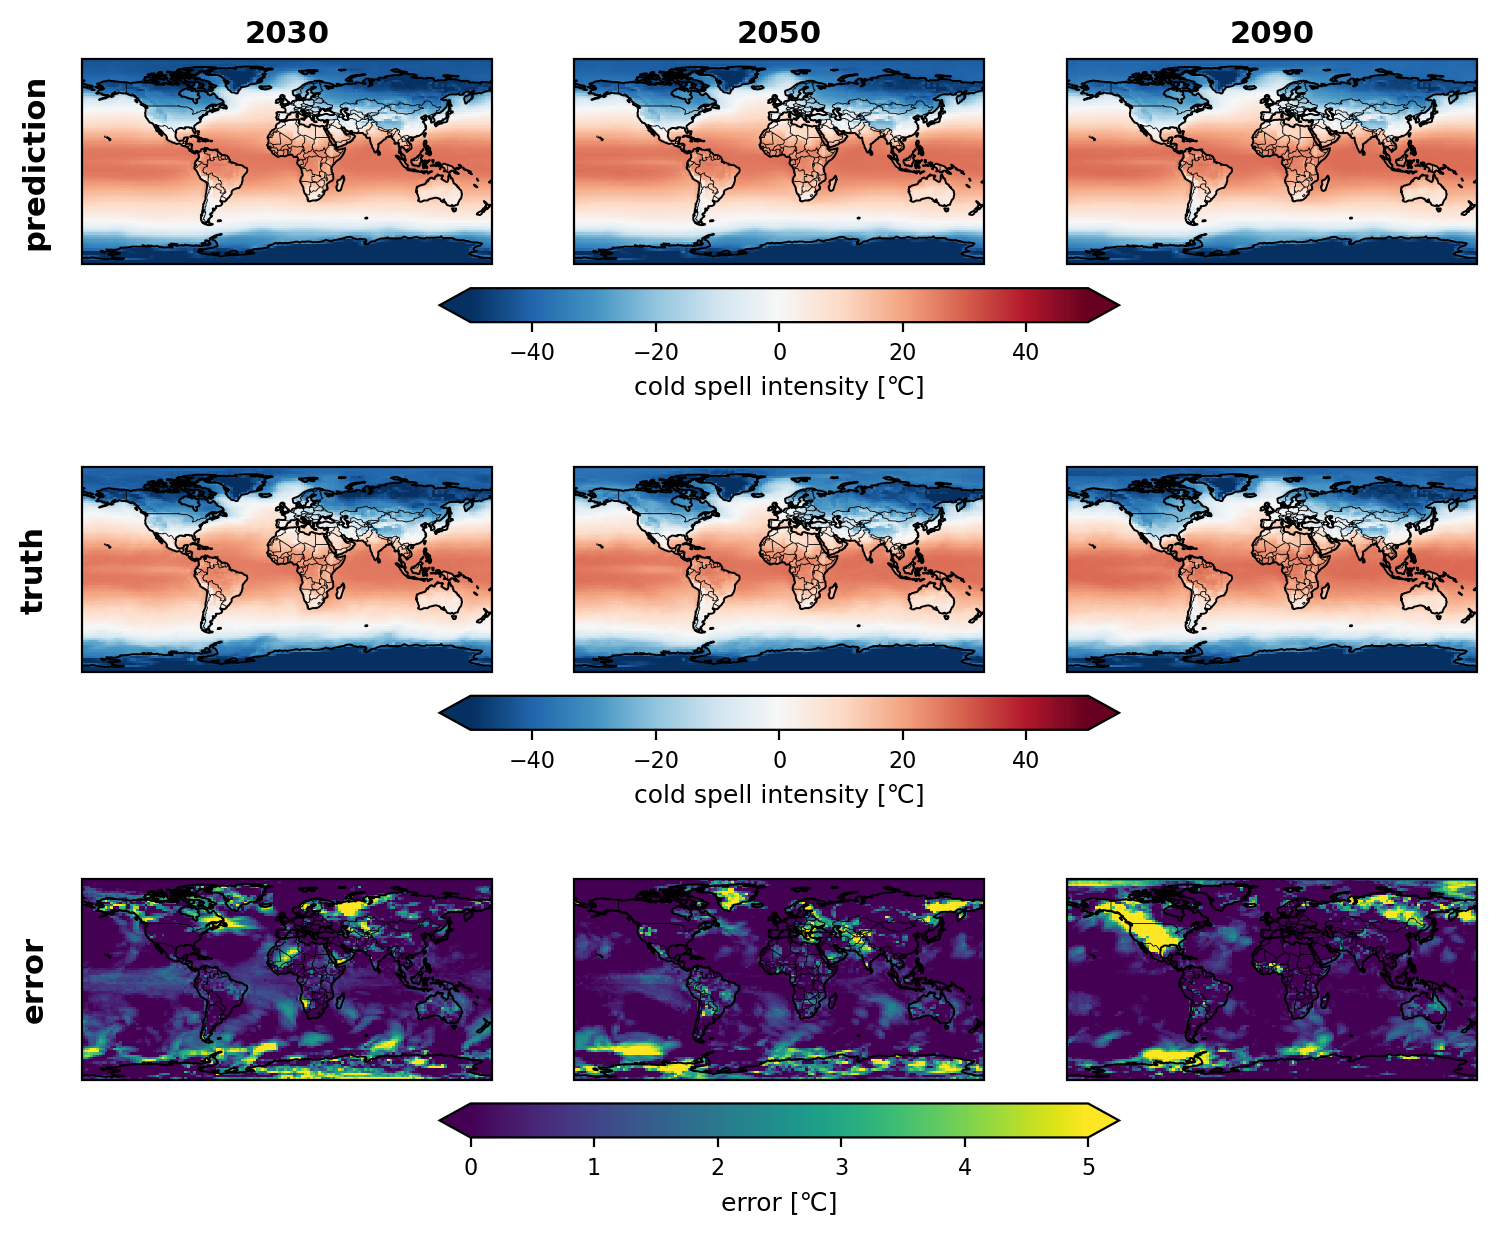

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

yrs = [2030, 2050, 2090]

# value ranges
vmin, vmax   = -50, 50        # pred & truth
rvmin, rvmax = 0, 5          # RMSE range
cmap = "RdBu_r"

nrows = 3
ncols = len(yrs)

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(3.*ncols, 2.5*nrows),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

row_titles = ["prediction", "truth", "error"]

# store a mappable for each row
mappables = [None] * nrows

for j, year in enumerate(yrs):

    da_pred = y_test_pre.sel(time=year)
    da_true = y_test_xr.sel(time=year)
    da_rmse = da_pred - da_true

    for row, da in enumerate([da_pred, da_true, da_rmse]):
        ax = axes[row, j]

        # choose ranges
        if row < 2:
            vmin_row, vmax_row = vmin, vmax
            cmap_row = cmap
        else:
            vmin_row, vmax_row = rvmin, rvmax
            cmap_row = "viridis"

        # plot
        m = da.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            vmin=vmin_row, vmax=vmax_row,
            cmap=cmap_row,
            add_colorbar=False
        )

        # save first mappable per row
        if mappables[row] is None:
            mappables[row] = m

        # coastlines
        ax.coastlines(linewidth=0.7)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)

        # remove axis labels
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")

        # column titles (years)
        if row == 0:
            ax.set_title(str(year), fontweight="bold", fontsize=11)

        # row labels
        if j == 0:
            ax.text(
                -0.08, 0.5, row_titles[row],
                transform=ax.transAxes,
                rotation=90,
                va="center", ha="right",
                fontsize=11, fontweight="bold"
            )

# colorbars for each row
for row in range(nrows):
    cbar = fig.colorbar(
        mappables[row],
        ax=axes[row, :],
        orientation="horizontal",
        fraction=0.1,
        pad=0.07,
        extend = "both"
    )
    cbar.ax.tick_params(labelsize=8)

    # add labels with [K]
    if row == 0:
        cbar.set_label("cold spell intensity [℃]", fontsize=9)
    elif row == 1:
        cbar.set_label("cold spell intensity [℃]", fontsize=9)
    else:
        cbar.set_label("error [℃]", fontsize=9)


Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

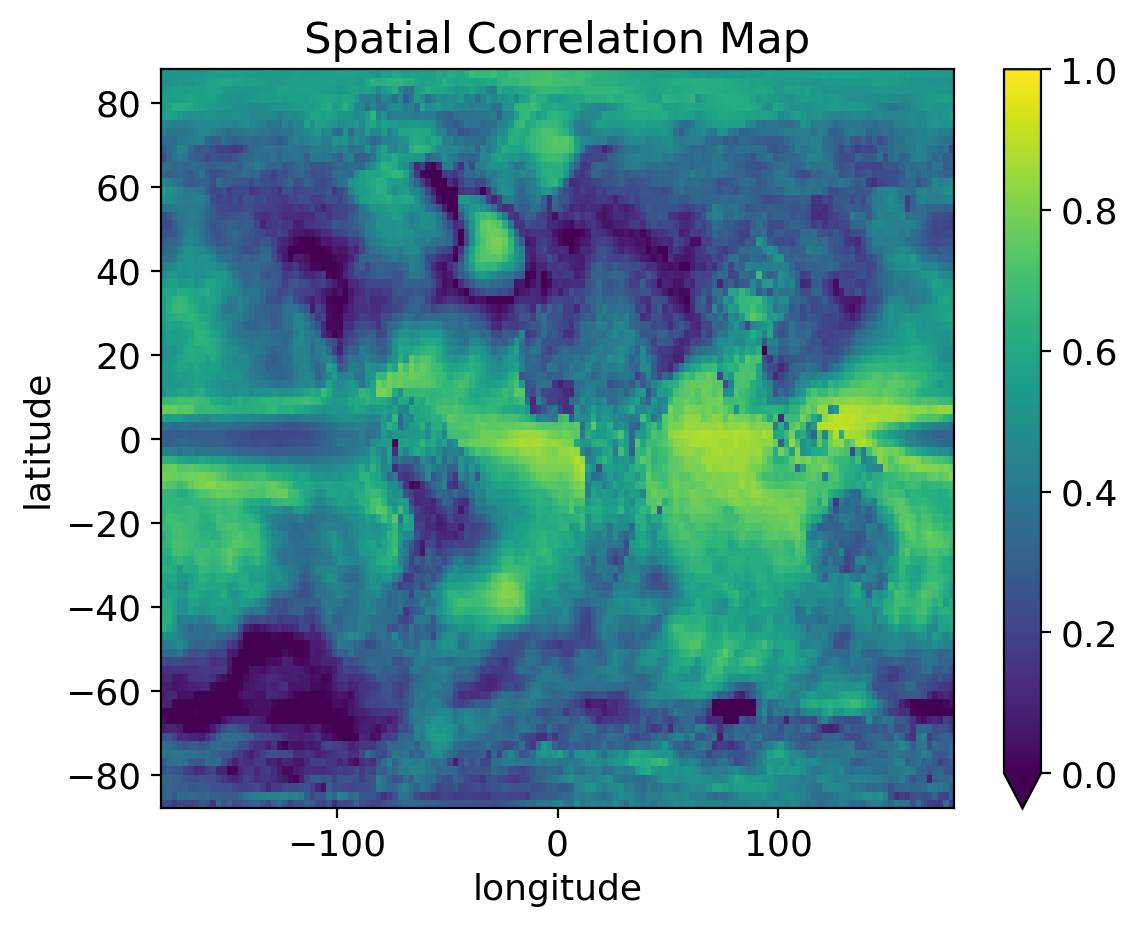

In [53]:
corr_map = xr.corr(y_test_mse_pre, y_test_xr, dim="time")
corr_map.plot(vmin=0, vmax=1, cmap="viridis")
plt.title("Spatial Correlation Map")
plt.show()


Text(0.5, 0, 'prediction − truth [K]')

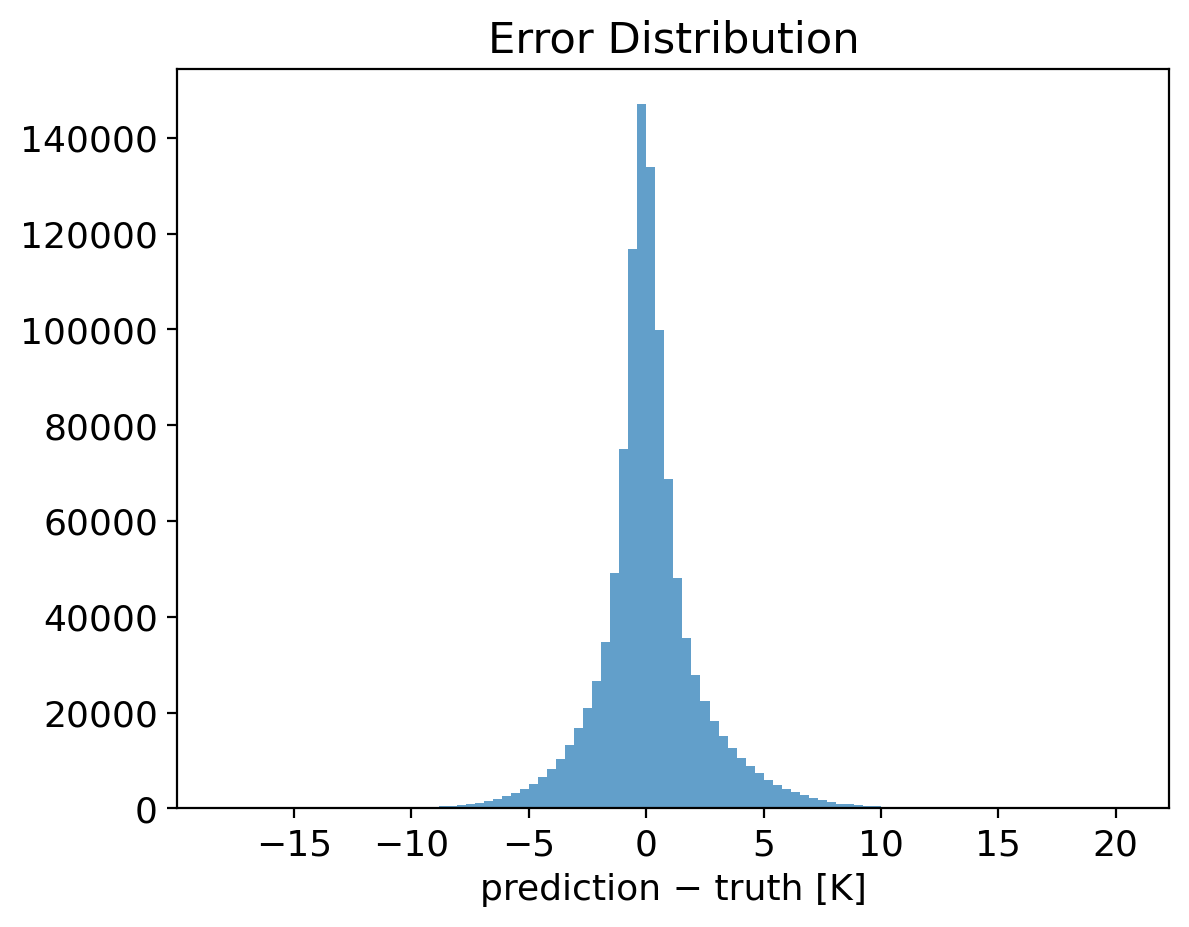

In [52]:
errors = (y_test_mse_pre - y_test_xr).values.flatten()

plt.hist(errors, bins=100, alpha=0.7)
plt.title("Error Distribution")
plt.xlabel("prediction − truth [K]")


Text(0, 0.5, 'temperature (°C)')

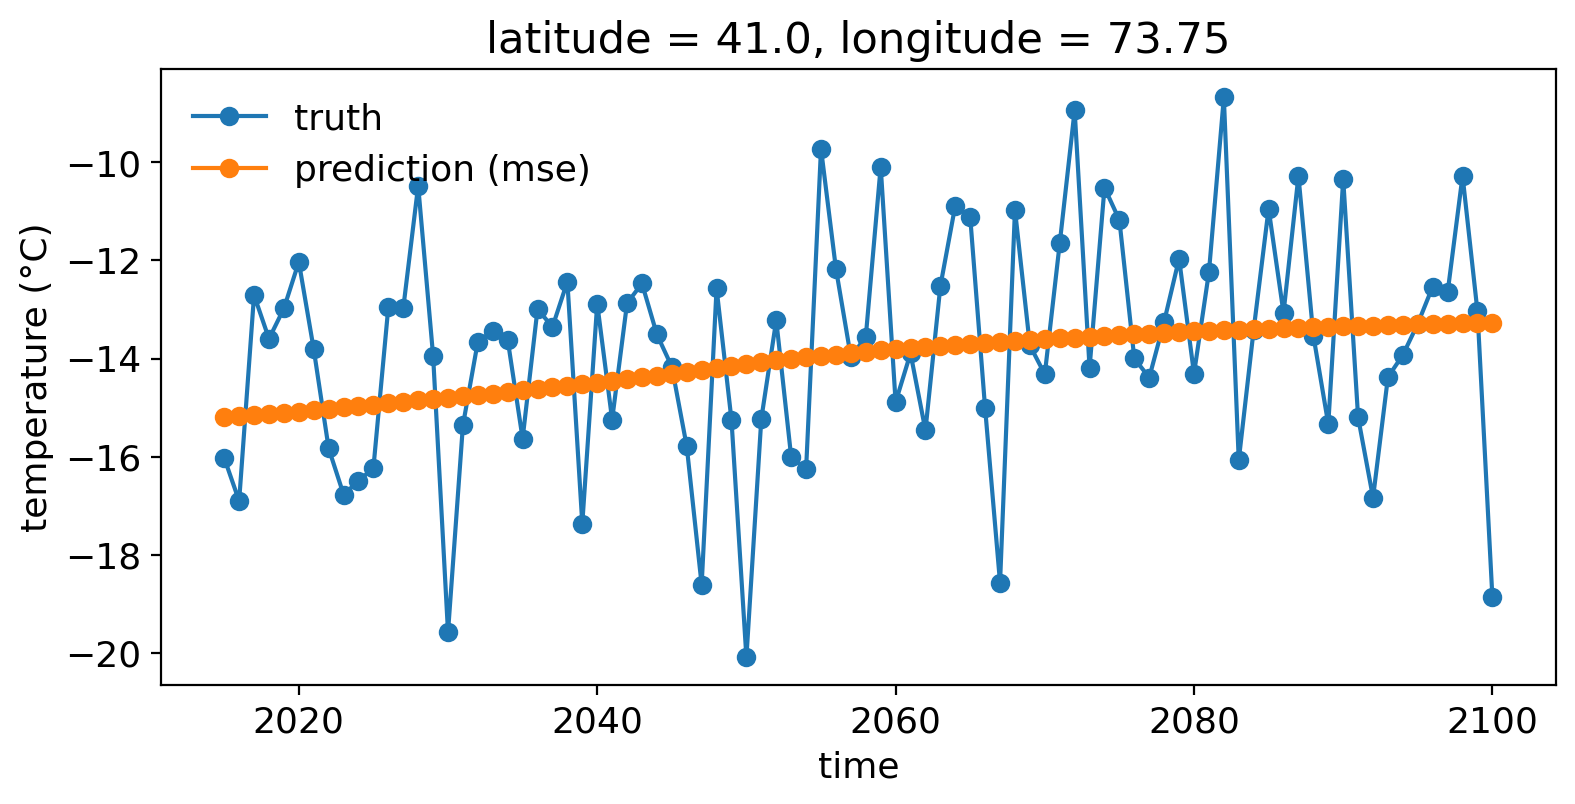

In [40]:
lat = 40.7128
lon = 74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').plot(marker='o',ax=ax,label='truth')
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').plot(marker='o',ax=ax,label='prediction (mse)')

ax.legend()
ax.set_ylabel('temperature (°C)')

Let's check the statistical comparison between truth and prediction.

In [41]:
# # combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').values
nyc_test_mse_pre = y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').values
# nyc_test_mae_pre = y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction_mse"] = nyc_test_mse_pre
print(df_nyc_test.head(10))

# # summary statistics of the dataframe
df_nyc_test.describe()

   time      truth  prediction_mse
0  2015 -16.025991      -15.199410
1  2016 -16.904858      -15.176756
2  2017 -12.705605      -15.153883
3  2018 -13.596947      -15.131388
4  2019 -12.978542      -15.107208
5  2020 -12.028224      -15.080530
6  2021 -13.809662      -15.051876
7  2022 -15.830596      -15.023484
8  2023 -16.771929      -14.996041
9  2024 -16.498934      -14.969072


,time,truth,prediction_mse
count,86.000000,86.000000,86.000000
mean,2057.500000,-13.784131,-14.041372
std,24.969982,2.333830,0.627856
min,2015.000000,-20.093859,-15.199410
25%,2036.250000,-15.251009,-14.609874
50%,2057.500000,-13.579363,-13.876253
75%,2078.750000,-12.525844,-13.464912
max,2100.000000,-8.676072,-13.273693


Finally we check whether the ML model can capture the time series of global average temperature 

In [ ]:
# def global_mean_std_plot(X,label,color,ax,var='tas'):
#     weights  = np.cos(np.deg2rad(X.latitude))
#     tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
#     tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
#     x = X.time.data

#     ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
#     ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

In [ ]:
# fig,ax = plt.subplots(figsize=(9,4))

# global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
# global_mean_std_plot(y_test_mse_pre,label='prediction (mse)',ax=ax,color='tab:orange')
# global_mean_std_plot(y_test_mae_pre,label='prediction (mae)',ax=ax,color='tab:brown')

# ax.set_xlabel('time')
# ax.set_ylabel('global mean temperature (°C)')
# ax.legend()
# plt.tight_layout()

In [ ]:
# # get global mean temperature
# def global_mean(X,var='tas'):
#     weights  = np.cos(np.deg2rad(X.latitude))
#     tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
#     return tas_mean

# tas_mean_xr = global_mean(y_test_xr)
# tas_mean_mse_pre = global_mean(y_test_mse_pre)
# tas_mean_mae_pre = global_mean(y_test_mae_pre)

# # put into dataframe
# df_globalmean_test = pd.DataFrame()
# df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
# df_globalmean_test["truth"] = tas_mean_xr
# df_globalmean_test["prediction_mse"] = tas_mean_mse_pre
# df_globalmean_test["prediction_mae"] = tas_mean_mae_pre
# print(df_globalmean_test.head(10))

# # summary statistics of the dataframe
# df_globalmean_test.describe()